# Imports


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3, VGG16, VGG19, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from keras.regularizers import l2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os

In [2]:
# Set the path to the dataset directory
BASEPATH = "../input/stanford-dogs-dataset/images/Images/"

In [3]:
# Set the directory to the dataset images
filelist  = []
for dirname, _, filenames in os.walk(BASEPATH):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))
print('Total number of images:', len(filelist))

Total number of images: 20580


In [4]:
# Split the file paths and the labels
Filepaths = []
labels = []
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2].split('-')[1]
    Filepaths.append(image_file)
    labels.append(label)
num_classes = len(set(labels)) 
print('Total number of labels:', num_classes)


Total number of labels: 120


In [5]:
# Create a Pandas dataframe to store the file paths and labels, and shuffle the dataframe
df = pd.DataFrame(list(zip(Filepaths, labels)), columns = ['Filepath', 'Labels'] )
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df.head()

,Filepath,Labels
0,../input/stanford-dogs-dataset/images/Images/n...,keeshond
1,../input/stanford-dogs-dataset/images/Images/n...,affenpinscher
2,../input/stanford-dogs-dataset/images/Images/n...,Scotch_terrier
3,../input/stanford-dogs-dataset/images/Images/n...,golden_retriever
4,../input/stanford-dogs-dataset/images/Images/n...,Old_English_sheepdog


In [7]:
# Get the count of each dog breed in the dataset
breed_count = pd.value_counts(df['Labels'], ascending=False)
print('Top 10 dog breeds:')
print(breed_count.tail(10))

Top 10 dog breeds:
Doberman                150
golden_retriever        150
malinois                150
Irish_water_spaniel     150
Eskimo_dog              150
affenpinscher           150
Bouvier_des_Flandres    150
clumber                 150
Pekinese                149
redbone                 148
Name: Labels, dtype: int64


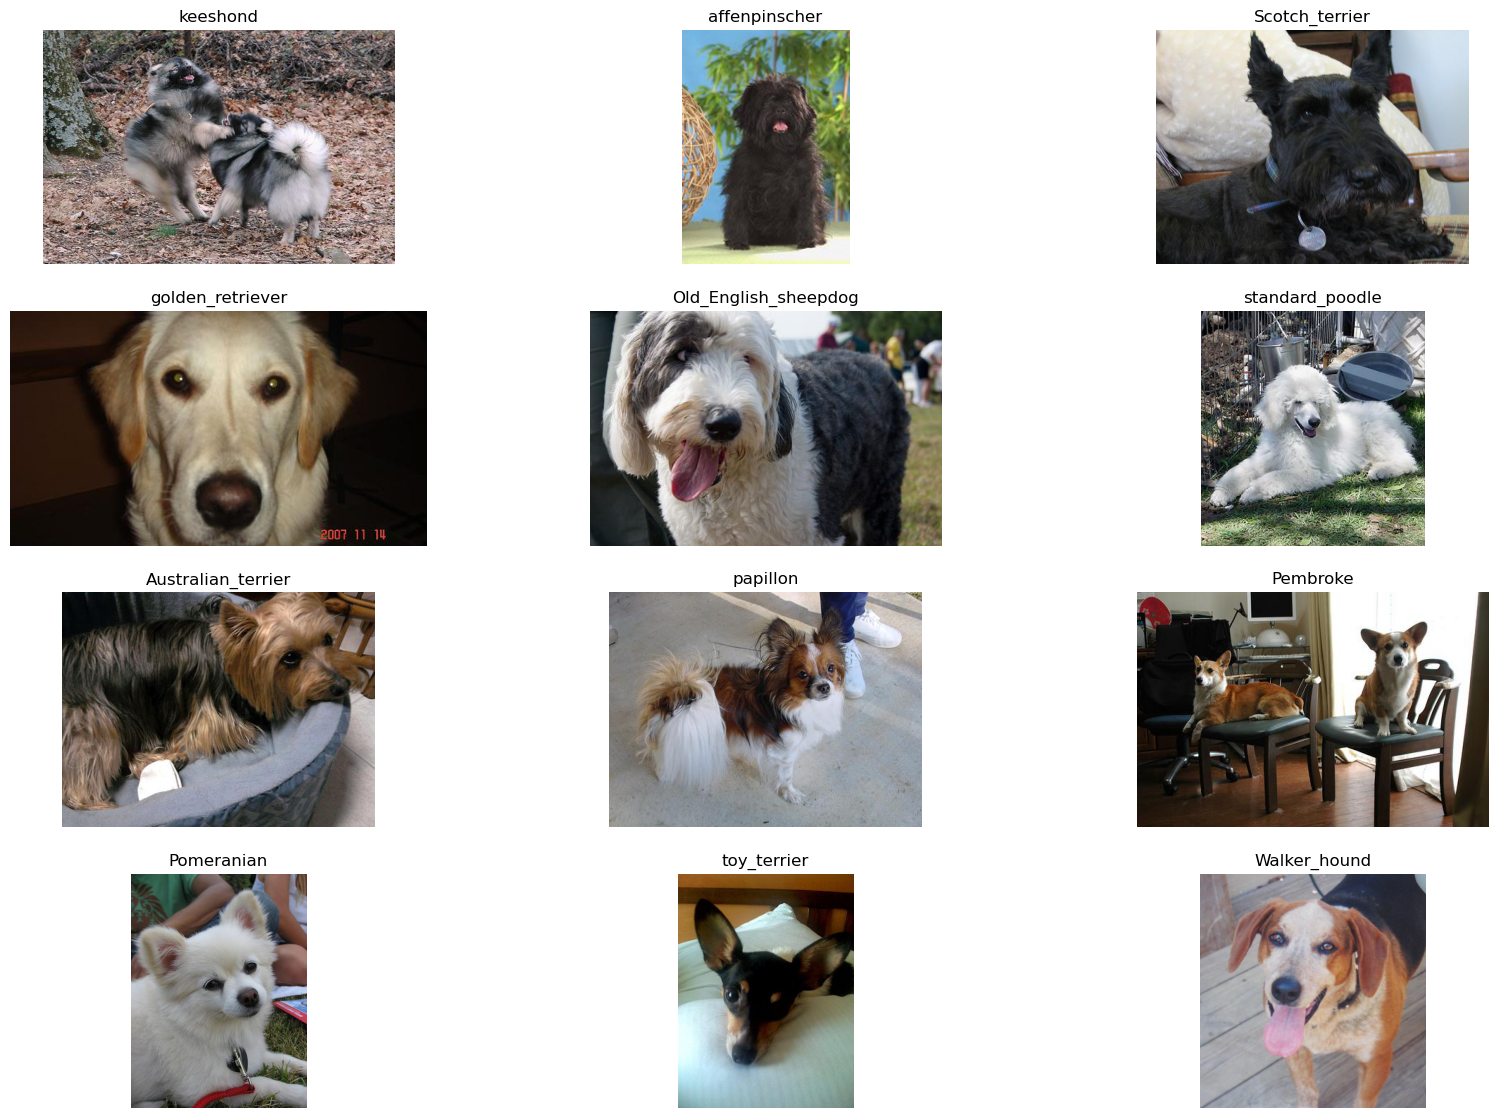

In [8]:
# Display some sample images from the dataset
fig, axis = plt.subplots(4, 3, figsize=(20, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    ax.axis('off')
plt.show()

In [9]:
# Split the dataset into training, validation, and testing sets
val_ratio = test_ratio = 0.2
train, test = train_test_split(df, test_size=test_ratio)
val, test = train_test_split(test, test_size=val_ratio)
print('Total number of samples:', len(df))
print('Number of training samples:', len(train))
print('Number of validation samples:', len(val))
print('Number of testing samples:', len(test))

Total number of samples: 20580
Number of training samples: 16464
Number of validation samples: 3292
Number of testing samples: 824


In [10]:
# Create an ImageDataGenerator object to augment the training data
img_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    horizontal_flip=True
)

In [11]:
batch_size = 64
target_size=(299, 299)

# Create generators for the training, validation, and testing sets
train_generator = img_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="Filepath",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=True,
    target_size=target_size
)

validation_generator = img_datagen.flow_from_dataframe(
    dataframe=val,
    x_col="Filepath",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=True,
    target_size=target_size
)


test_generator = img_datagen.flow_from_dataframe(
    dataframe=test,
    x_col="Filepath",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=True,
    target_size=target_size
)


Found 16464 validated image filenames belonging to 120 classes.
Found 3292 validated image filenames belonging to 120 classes.
Found 824 validated image filenames belonging to 120 classes.


In [12]:
input_shape = target_size + (3,)
# Load the model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Get the base model name
base_model_name = "InceptionV3"

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) # Add L2 regularization to this layer
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

87910968/87910968 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [13]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Check what is the status of the last 100 layers
for layer in model.layers[-10:]:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

Layer: activation_93, Trainable: False
Layer: mixed10, Trainable: False
Layer: global_average_pooling2d, Trainable: True
Layer: dense, Trainable: True
Layer: dropout, Trainable: True
Layer: dense_1, Trainable: True
Layer: dropout_1, Trainable: True
Layer: dense_2, Trainable: True
Layer: dropout_2, Trainable: True
Layer: dense_3, Trainable: True


In [15]:
# Define the callbacks

# Get the current timestamp
timestamp = time.strftime("%Y_%m_%d-%H%_M")

# Create the ModelCheckpoint callback for validation loss
checkpoint_loss_filepath = f'{base_model_name}_best_model_loss_{timestamp}.h5'
checkpoint_loss_callback = ModelCheckpoint(
    filepath=checkpoint_loss_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Create the ModelCheckpoint callback for validation accuracy
checkpoint_accuracy_filepath = f'{base_model_name}_best_model_accuracy_{timestamp}.h5'
checkpoint_accuracy_callback = ModelCheckpoint(
    filepath=checkpoint_accuracy_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# a reducing lr callback to reduce lr when val_loss doesn't decrease
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, verbose=1, mode='min',
                              min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=4)


callbacks = [checkpoint_loss_callback, checkpoint_accuracy_callback, reduce_lr, early_stop]

In [16]:
# Train the model
epochs=30

history = model.fit(
train_generator,
steps_per_epoch=train_generator.n // train_generator.batch_size,
epochs=epochs,
validation_data=validation_generator,
validation_steps=validation_generator.n // validation_generator.batch_size,
callbacks=callbacks
)

Epoch 1/30
257/257 [==============================] - ETA: 0s - loss: 4.0024 - accuracy: 0.5091
Epoch 1: val_loss improved from inf to 1.67764, saving model to InceptionV3_best_model_loss_2023_03_25-08 2.h5

Epoch 1: val_accuracy improved from -inf to 0.71998, saving model to InceptionV3_best_model_accuracy_2023_03_25-08 2.h5
257/257 [==============================] - 648s 2s/step - loss: 4.0024 - accuracy: 0.5091 - val_loss: 1.6776 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 2/30
257/257 [==============================] - ETA: 0s - loss: 1.7964 - accuracy: 0.6701
Epoch 2: val_loss improved from 1.67764 to 1.41461, saving model to InceptionV3_best_model_loss_2023_03_25-08 2.h5

Epoch 2: val_accuracy improved from 0.71998 to 0.75306, saving model to InceptionV3_best_model_accuracy_2023_03_25-08 2.h5
257/257 [==============================] - 554s 2s/step - loss: 1.7964 - accuracy: 0.6701 - val_loss: 1.4146 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 3/30
257/257 [===========================

In [17]:
# Evaluate the model on the test set
loss, acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

12/12 [==============================] - 22s 2s/step - loss: 0.6453 - accuracy: 0.8555
loss on the test set is 0.65
accuracy on the test set is 0.855


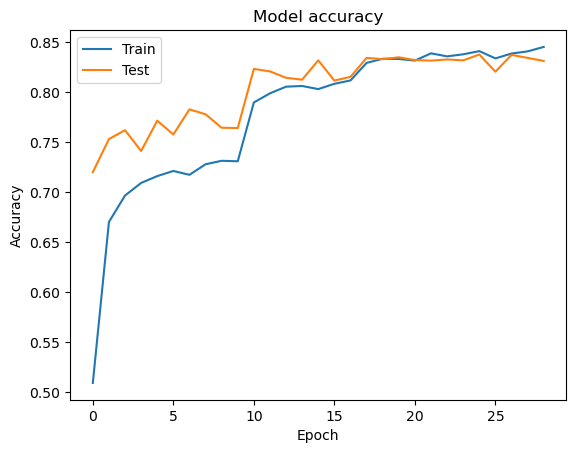

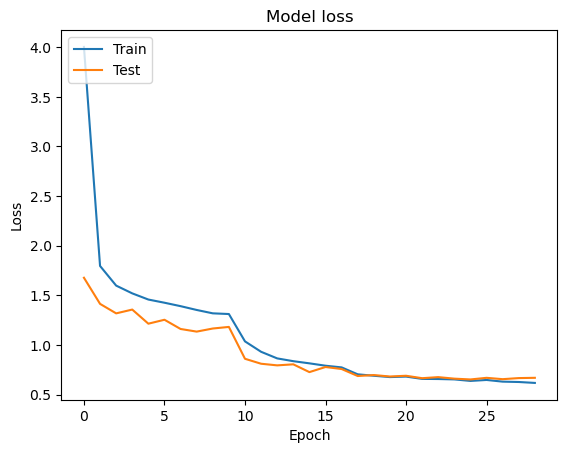

In [18]:
# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
model.save(f'{base_model_name}_model_{timestamp}.h5')